In [1]:
import numpy as np

import torch
import torch.optim as optim
from torch import nn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# from tqdm import tqdm

from scipy.linalg import block_diag
from scipy.special import binom

from itertools import combinations

from analysis import bootstrap

from typing import Callable
from numpy.typing import ArrayLike

from mcmc import *
from model import *
from deformations import *
from losses import *
from linalg import *
from observables import *

### Remarks

* [wrapped normal distributions](https://mpmath.org/doc/0.19/functions/elliptic.html#jacobi-theta-functions)



## Deformation Space



Recall that the following three spaces are all diffeomorphic 

$$Q = \{ z \in \mathbb{C}^{n+1} \mid \sum_k z_k^2 = 1 \}$$

$$TS^n = \{ (x,y) \mid x \in S^n, \langle x , y \rangle = 0\}$$

$$S^n \times S^n / \Delta = \{(u,v) \mid u,v \in S^n, u \neq v \}$$

The diffeomorphism are given by 

$$\Psi \colon TS^n \to Q \quad , \quad (x,y) \mapsto (x \sqrt{1 + \lVert y \rVert^2} + i y)$$

and 

$$\Phi \colon S^n \times S^n / \Delta \to TS^n \quad , \quad (u,v) \mapsto \left(u, \frac{v - \langle u, v\rangle u}{1 - \langle u, v\rangle}\right)$$

### The Model

For $z,w$ in $\mathbb{CP}^n$: 

$$S(z,w) = -\beta \sum_{a,b} z_a \bar z_b w_b \bar w_a$$

Now, forget about the $U(1)$ invariance (can be integrated out since compact) and fix the non-compact part of the $\mathbb{C}^*$ gauge group via 

$$\delta( \lvert z \rvert^2 - 1)  \delta( \lvert w \rvert^2 - 1)$$ 

with 

$$\lvert z \rvert^2 = \sum_a \lvert z_a \rvert^2$$

Rewrite it in real variables: let $z_a = x_a + i y_a$, $w_a = u_a + i v_a$ and define _real_ vectors $Z = (\dots,x_a,y_a,\dots)$ and $W = (\dots,u_a,v_a,\dots)$ with $\lVert Z \rVert^2 = 1$ and likewise for $W$.

Define $h = id + J$ where $J = diag(\sigma_y, \dots, \sigma_y)$ where 

$$\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix}$$

Then 

$$S(Z,W) = \beta \langle Z , T W \rangle \langle W , T Z \rangle$$

where $\langle \dots \rangle$ is the standard inner product in $\mathbb{R}^{2n+2}$.

In [2]:
# DIFFEOMORPHISMS TS^n <-> Q <-> S^n x S^n / Delta

def Psi(p): # TS^n -> Q
    x, y = p # unpack point (into base point x, tangent vector y)

    z = x*np.sqrt(1 + np.inner(y,y)) + y*1j

    return z

def invPsi(z): # Q -> TS^n
    re, im = (z.real,z.imag) # seperate into re and im part
    
    x = re / np.sqrt(1 + np.inner(im,im))
    y = im
    
    return (x,y)

def Phi(p): # S^n x S^n / Delta -> TS^n
    u, v = p # unpack p

    x = u # base point
    y = (v - np.inner(u,v)*u) / (1 - np.inner(u,v)) # tangent vector 

    return (x,y)

def invPhi(p): # TS^n -> S^n x S^n / Delta
    x,y = p # unpack base point, tangent vector

    u = x
    v = (x*(np.inner(y,y) - 1) + 2*y ) / (np.inner(y,y) + 1)

    return u, v


# HERMITIAN INNER PRODUCT 

def h(n:int,Z:np.ndarray,W:np.ndarray) -> np.ndarray:
    """ 
    Quadratic form h used in action functional 

    :param n: complex dimension of CP^n
    :type n: int

    :param Z: (samples,2n + 2,1) real column vector 
    :type Z: np.ndarray

    :param W: (samples,2n + 2,1) real column vector 
    :type W: np.ndarray

    :returns: h(Z,W) for each sample
    :rtype: np.ndarray
    """
    id = np.eye(2*(n + 1))

    sigma_y = np.array([[0,-1j],[1j,0]])

    J = block_diag(*[sigma_y for _ in range(n+1)])

    # result = np.inner(Z.flatten(), ((id + J) @ W).flatten())
    result = ( Z.transpose(0,-1,1) @ ( (id + J) @ W) ).flatten()

    return result

def Scmplx(z:complex,w:complex,beta:float) -> float:
    return  - beta * np.inner(z,w.conjugate()) * np.inner(w, z.conjugate())

# TOY MODEL ACTION FUNCTIONAL

def S(n:int, Z:np.ndarray,W:np.ndarray,beta:float) -> float: # action on real variables
    return  - beta * h(n,Z,W) * h(n,W,Z)

# 2X2 ROTATION MATRIX FOR SAMPLING SPHERE
def R(t:float) -> np.ndarray:
    """
    2x2 roation matrix 

    :param t: rotation angle
    :type t: float

    :returns: rotation matrix np.array([[cos(t),-sin(t)],[sin(t),cos(t)]])
    :rtype: np.ndarray
    """

    c = np.cos(t)
    s = np.sin(t)

    return np.array([[c,-s],[s,c]])

# LINEAR ALGEBRA

def inner(a,X): # inner product <X,a>
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return X.transpose(0,-1,1) @ a

def outer(a,X): # outer product 
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return a * X.transpose(0,-1,1) 

def proj(a,X): # projection onto X

    inner_Xa = inner(X,a)
    
    return inner_Xa * X / inner(X,X)

def proj_perp(a,X): # proj perpendicular 
    return a - proj(a,X)

# JACOBIAN TOY MODEL

def M(a,X):
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    id = np.eye(X.shape[1])

    inner_Xa = inner(X,a)
    inner_XX = inner(X,X)

    return  - id * inner_Xa  - outer(a,X) / inner_XX +  2*inner_Xa * outer(X,X) / inner_XX**2

def Jac(a,X):

    m = X.shape[1] # = 2n + 2

    Y = proj_perp(a,X)

    lam = np.sqrt(1 + inner(Y,Y)) # shape (samples,1,1)

    id = np.eye(X.shape[1])

    MM = M(a,X)

    J = id*lam + outer( (MM @ Y), X) / lam + 1j*MM

    det = np.linalg.det(J) # shape (samples,)

    return det / lam.flatten()**2 #(lam - 1j * inner(a,X))**(m-1)  # WHY DONT WE HAVE TO RETURN det / lam.flatten()**2 ? the extra factor should come from the delta function constraint

# COMPLEXIFICATION 

def tildeZ(a,X): # paramerisation of (analytical continuation of) Z

    Y = proj_perp(a,X)

    return X * np.sqrt(1 + inner(Y,Y)) + 1j*Y

# MCMC

def sweep_sphere(phi:list,pairs:list,f) -> int:  
    """
    sweeping the sphere

    :param n: complex dimension CP^n
    :type n: int
    """

    alpha = 0 # number accepted

    # LOOP OVER COMPONENTS 
    for pair in pairs:
        a,b = pair # unpack indices
        phi_old = phi[-1] # current state 

        # SAMPLE 2x2 ROTATION ANGLE
        theta = np.random.normal(loc=0,scale=1)

        # ROTATE COMPONENT
        v = np.array([phi_old[a],phi_old[b]])
        vnew = R(theta) @ v

        # PROPOSE NEW STATE
        phi_new = phi_old.copy()
 
        phi_new[a] = vnew[0]
        phi_new[b] = vnew[1]
    
        # ACCEPTENCE PROBABILITIES
        A = np.minimum(1, f(phi_new[np.newaxis,:,:]) / (f(phi_old[np.newaxis,:,:])) ) # newaxis since f takes list of vectors: shape = (smaples,2n+2,1)

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
        
        if p <= A : # accept if p < A
            phi.append(phi_new)
            alpha += 1
        else:
            phi.append(phi_old)

    return alpha / len(pairs)


def MCMC_toy(n:int, Z0:complex,W0:complex,beta:float,N_steps:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    :param n: complex dimension CP^n 
    :type n: int
    """

    N = 2*n + 2 # real dimension (before quotient by C^*)
    pairs = list(combinations(np.arange(N),2)) # indices of pairs to rotate

    # SETUP
    Z = [Z0] 
    W = [W0]

    alpha = 0 # number accepted

    expSw = lambda z: np.exp( -S(n,z,W[-1][np.newaxis,:,:],beta) ) # w fixed
    expSz = lambda w: np.exp( -S(n,Z[-1][np.newaxis,:,:],w,beta) ) # z fixed

    for _ in tqdm(range(N_steps)): # tqdm for progress bar

        alpha += sweep_sphere(phi=Z,pairs=pairs,f=expSw) 
        alpha += sweep_sphere(phi=W,pairs=pairs,f=expSz)
       
    samples_Z, samples_W = (np.array(Z)[burnin::k], np.array(W)[burnin::k])

    acception_rate = alpha / (2*N_steps) 

    return (samples_Z, samples_W, acception_rate)



## Undeformed Path Integral

In [ ]:
n = 2

# INITIAL POINTS ON SPHERE
Z0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
Z0 /= np.linalg.norm(Z0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)

N_steps = 10_000

t0 = time.time()

obs = []

Nbeta = 10

for beta in range(1,Nbeta):

    Z_samples, W_samples, alpha = MCMC_toy(n=n,Z0=Z0,W0=W0,beta=beta,N_steps=N_steps,burnin=200,k=5)
    obs.append(- S(n,Z_samples,W_samples,beta).real.mean()/beta)

    print(f'{beta}/{Nbeta}',end='\r')


print(f'running time: {time.time() - t0:.2f}s')


100%|██████████| 10000/10000 [00:25<00:00, 395.18it/s]


100%|██████████| 10000/10000 [00:25<00:00, 399.14it/s]


100%|██████████| 10000/10000 [00:26<00:00, 384.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 375.74it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.99it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.05it/s]


100%|██████████| 10000/10000 [00:26<00:00, 381.66it/s]


100%|██████████| 10000/10000 [00:25<00:00, 387.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 378.49it/s]


running time: 235.13s


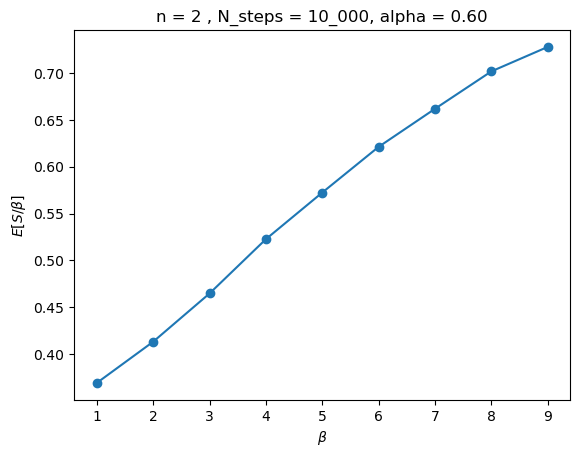

In [5]:
beta = range(1,Nbeta)
plt.plot(beta,obs,'o-')
plt.xlabel(f'$\\beta$')
plt.ylabel(f'$E[S / \\beta]$')
plt.title(f'{n = } , {N_steps = :_d}, {alpha = :.2f}');

## Deformation 

Idea: 

1. deform $S^{2n + 1} \to Q$ via $Z \to \tilde Z = Z + i \zeta_a(Z)$  


2. parametrize $Q$ via $TS^{2n+1}$:

   $$Q \ni \tilde Z(X) = X \sqrt{1 + \lVert Y_a(X) \rVert^2} + i Y_a(X)$$

   where $X \in S^{2n +1 }$ and 
   
   $$Y(X,a) = \frac{a - \langle a, X \rangle X}{1 - \langle a, X \rangle} \in T_X S^{2n + 1} \quad , \quad a \in \mathbb{R}^{2n + 2}$$

3. compute 

   $$\langle \mathcal{O}(Z) \rangle _Q = \langle \det J(X) \mathcal{O}(\tilde Z(X)) e^{- (S(\tilde Z(X)) - S(X))}\rangle _{e^{-S(X)}}$$



To do:

1. choose $a \in \mathbb{R}^{2n + 1}$ fixed constant

2. compute $Y_a(X)$ 

3. compute $\lambda(a,X) = \sqrt{1 + \lVert Y_a(X) \rVert^2}$

4. compute $J_{ij} = \lambda \delta_{ij} + \frac{(M Y)_i X_j}{\lambda} + i M_{ij}$ where

$$M_{ij} = \partial_{X_i}(Y_a(X))_j = \frac{a_i(a_j - X_j) - \delta_{ij} \langle a, X\rangle (1 - \langle a, X\rangle )}{(1 - \langle a, X\rangle)^2}$$



In [3]:
def fuzzy_one(X_samples,W_samples,beta):
    n = (X_samples.shape[1] - 2 ) // 2

    a = np.ones_like(X_samples)

    tildeZ_samples = tildeZ(a,X_samples)

    obs = ( Jac(a,X_samples) * np.exp( - ( S(n,tildeZ_samples,W_samples,beta) - S(n,X_samples,W_samples,beta) ) ) )

    return obs


In [118]:
n = 2

# SETUP OBSERVABLE
beta = 1
fuzzy_one_mean = lambda samples: fuzzy_one(X_samples=samples,W_samples=W_samples,beta=beta).mean()

ones = []
err = []

# INITIAL POINTS ON SPHERE
X0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
X0 /= np.linalg.norm(X0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)


# SETUP MONTE CARLO
N_steps = 5_000
burnin = 200
skip = 5

# SETUP ERRORS (BOOTSTRAP)
Nboot = 200

# TIME 
t0 = time.time()

for _ in range(50):
    X_samples, W_samples, alpha = MCMC_toy(n=n,Z0=X0,W0=W0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)

    # a = np.random.normal(size=X_samples.shape) #np.ones_like(X_samples)
    # tildeZ_samples = tildeZ(a,X_samples)
    # obs = Jac(a,X_samples) * np.exp( - ( S(n,tildeZ_samples,W_samples,beta) - S(n,X_samples,W_samples,beta) ) )
    # ones.append(obs.real.mean())
    # err.append(obs.std() / np.sqrt(len(X_samples)))

    ones.append(fuzzy_one_mean(X_samples))
    err.append(bootstrap(X_samples,Nboot=Nboot,f=fuzzy_one_mean)[1])
    

print(f'running time: {time.time() - t0:.2f}s\n')

# print(f'{alpha = }\n')
# print(f'{obs.mean() = } \n')
# print(f'{obs.std() / np.sqrt(len(X_samples)) = }')

100%|██████████| 5000/5000 [00:13<00:00, 383.16it/s]


running time: 851.21s



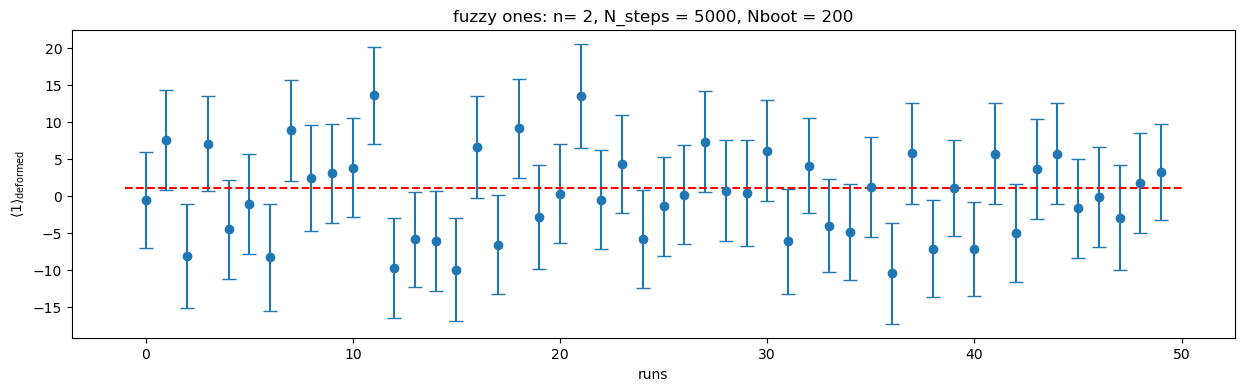

In [119]:
real_ones = [one.real for one in ones]

t = np.arange(len(real_ones))

fig = plt.figure(figsize=(15,4))

plt.errorbar(t, real_ones, yerr=err, fmt='o', capsize=5, label="Data with Error")
plt.hlines(y=1.0,xmin=-1,xmax=len(real_ones),colors='red',ls='--')
plt.title(f'fuzzy ones: {n= }, {N_steps = }, {Nboot = }')
plt.ylabel(r'$\langle 1 \rangle_{\text{deformed}}$')
plt.xlabel('runs');


## Grad Descent Optimization

In [ ]:
# FINDING NULLSTELLEN - PEDESTRIAN WAY
def f(x):
    return x**2

x = torch.tensor(1.5,requires_grad=True) # initial guess

lr = 0.1 # learning rate

epochs = 20 # nb optimization steps

print(f'{x = }')

# OPTIMIZATION 
for epoch in range(epochs):
    y = f(x)
    y.backward()

    with torch.no_grad():
        x -= lr * x.grad
        print(f'{x = } \t {x.grad = }')
    x.grad.zero_()

x = tensor(1.5000, requires_grad=True)
x = tensor(1.2000, requires_grad=True) 	 x.grad = tensor(3.)
x = tensor(0.9600, requires_grad=True) 	 x.grad = tensor(2.4000)
x = tensor(0.7680, requires_grad=True) 	 x.grad = tensor(1.9200)
x = tensor(0.6144, requires_grad=True) 	 x.grad = tensor(1.5360)
x = tensor(0.4915, requires_grad=True) 	 x.grad = tensor(1.2288)
x = tensor(0.3932, requires_grad=True) 	 x.grad = tensor(0.9830)
x = tensor(0.3146, requires_grad=True) 	 x.grad = tensor(0.7864)
x = tensor(0.2517, requires_grad=True) 	 x.grad = tensor(0.6291)
x = tensor(0.2013, requires_grad=True) 	 x.grad = tensor(0.5033)
x = tensor(0.1611, requires_grad=True) 	 x.grad = tensor(0.4027)
x = tensor(0.1288, requires_grad=True) 	 x.grad = tensor(0.3221)
x = tensor(0.1031, requires_grad=True) 	 x.grad = tensor(0.2577)
x = tensor(0.0825, requires_grad=True) 	 x.grad = tensor(0.2062)
x = tensor(0.0660, requires_grad=True) 	 x.grad = tensor(0.1649)
x = tensor(0.0528, requires_grad=True) 	 x.grad = tenso

In [33]:
# FINDING NULLSTELLEN - MODEL

class Nullstellen(nn.Module):
    def __init__(self,f,x0:float):
        super().__init__()

        self.f = f # function whose zeros we want to find 
        self.x = nn.Parameter( torch.tensor([x0]) )

    def forward(self):
        return self.f(self.x)

# HYPERPARAMETER
alpha = 0.01 # learning rate
eps = 1e-8 # stopping cond 
next = True
x0 = np.random.randn()
convergence_steps = 0

# MODEL
model = Nullstellen(f=lambda x: x**2,x0=x0)
optimizer = optim.SGD(model.parameters(),lr=alpha)
print(f'init:\n{model.x}')

# RUN
while next:
    convergence_steps += 1
    y = model()
    y.backward()
    optimizer.step()
    optimizer.zero_grad()
    if y < eps:
        next = False

print(f'\nfinal:\n{model.x}')
print(f'\n{convergence_steps = }')


init:
Parameter containing:
tensor([0.4938], requires_grad=True)

final:
Parameter containing:
tensor([9.7932e-05], requires_grad=True)

convergence_steps = 422


In [5]:
# GENERATE SAMPLES
n = 2 # cmplx dim

# SETUP OBSERVABLE
beta = 1

# INITIAL POINTS ON SPHERE
x0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
x0 /= np.linalg.norm(x0)

y0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
y0 /= np.linalg.norm(y0)


# SETUP MONTE CARLO
N_steps = 5_000
burnin = 200
skip = 5

x, y, alpha = MCMC_toy(n=n,Z0=x0,W0=y0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)

100%|██████████| 5000/5000 [00:12<00:00, 398.36it/s]


In [ ]:
def A(phi,beta):
    """
    phi = X, Y 
    """
    N = phi.shape[-2]
    n = (N - 2) // 2 # n in CP^n

    # PUT CST OUTSIDE FCT CALL
    id = torch.eye(N)

    sigma_y = np.array([[0,-1j],[1j,0]]) # 2nd Pauli

    T = id + torch.tensor( block_diag(*[sigma_y for _ in range(n+1)]) ) 
    # END CST

    X = phi[:,0]
    Y = phi[:,1]

    hXY = ( X.transpose(-1,-2) @ (T @ Y) ).flatten()

    hYX =  ( Y.transpose(-1,-2) @ (T @ X) ).flatten()

    return - beta * hXY * hYX
    
def fuzzy_one(a,phi,beta):
    X = phi
    N = x.shape[1] # 2n + 2

    # ALGEBRA
    inner_aX = a.transpose(-1,-2) @ X
    outer_aX = a @ X.transpose(-1,-2)

    inner_XX = X.transpose(-1,-2) @ X
    outer_XX = X @ X.transpose(-1,-2)

    Y = a - inner_aX / inner_XX * X # P^perp(a,X)

    inner_YY = Y.transpose(-1,-2) @ Y

    id = torch.eye(N)

    # ACTION FUNCTIONAL

    A0 = A(X,beta)


    # COMPLEXIFICATION 

    tildeX = X * torch.sqrt(1 + inner_YY) + 1j*Y

    Atilde = A(tildeX,beta)

    # JACOBIAN

    lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1), torch.tensor

    M = - id * inner_aX / inner_XX - outer_aX / inner_XX +  2*inner_aX * outer_XX / inner_XX**2

    J = id*lam + (M @ Y) @ X.transpose(-1,-2) / lam + 1j*M

    det = torch.det(J) # shape (samples, #particles) -> need to multiply
    detJ = det / lam.squeeze(dim=(-1,-2))**2 

    detJ = torch.prod(detJ,dim=-1) # shape (samples,)

    assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 


    OO = ( detJ * torch.exp( - ( Atilde - A0 ) ) ) # observable 

    return OO

def real2cmplx(phi):
    # phi.shape = (... , N, 1)

    z = phi[...,::2,:] + 1j*phi[...,1::2,:]
    zbar = phi[...,::2,:] - 1j*phi[...,1::2,:]

    return (z,zbar)

def two_pt_fct(phi):
    zeta, zetabar = real2cmplx(phi)

    z = zeta[:,0]
    zbar = zetabar[:,0]
    w = zeta[:,1]
    wbar = zetabar[:,1]

    return (z[:,0]*wbar[:,0]*w[:,1]*zbar[:,1]).squeeze(dim=-1) 

def one_pt_fct(phi):
    zeta, zetabar = real2cmplx(phi)

    z = zeta[:,0]
    zbar = zetabar[:,0]
    
    return (z[:,0]*zbar[:,1]).squeeze(dim=-1) 

def def_obs(obs):
    
    def compute(a,phi,beta):
        X = phi
        N = x.shape[1] # 2n + 2

        # ALGEBRA
        inner_aX = a.transpose(-1,-2) @ X
        outer_aX = a @ X.transpose(-1,-2)

        inner_XX = X.transpose(-1,-2) @ X
        outer_XX = X @ X.transpose(-1,-2)

        Y = a - inner_aX / inner_XX * X # P^perp(a,X)

        inner_YY = Y.transpose(-1,-2) @ Y

        id = torch.eye(N)

        # ACTION FUNCTIONAL

        A0 = A(X,beta)


        # COMPLEXIFICATION 

        tildeX = X * torch.sqrt(1 + inner_YY) + 1j*Y

        Atilde = A(tildeX,beta)

        # JACOBIAN

        lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1), torch.tensor

        M = - id * inner_aX / inner_XX - outer_aX / inner_XX +  2*inner_aX * outer_XX / inner_XX**2

        J = id*lam + (M @ Y) @ X.transpose(-1,-2) / lam + 1j*M

        det = torch.det(J) # shape (samples, #particles) -> need to multiply
        detJ = det / lam.squeeze(dim=(-1,-2))**2 

        detJ = torch.prod(detJ,dim=-1) # shape (samples,)

        assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 


        OO = (obs(tildeX) * detJ * torch.exp( - ( Atilde - A0 ) ) ) # observable 

        return OO
    
    return compute

def grab(x):
    return x.detach().cpu().numpy()

def loss(obs):
    return obs.var()

def logloss(obs):
    return torch.log(obs.var())

In [ ]:
# SDG OPTIMIZATION 
class DefObs(nn.Module):
    def __init__(self,obs,a,beta):
        """
    
        obs = observable
        a,b = (contour) deformation parameters 
        """
        super().__init__()

        self.a = nn.Parameter(a) # deformation parameter(s)
        self.beta = beta
        self.obs = obs

    def forward(self,samples):
        a_ = self.a.cdouble().unsqueeze(0)

        return self.obs(a_,samples,self.beta)

100%|██████████| 1000/1000 [00:08<00:00, 112.76it/s]


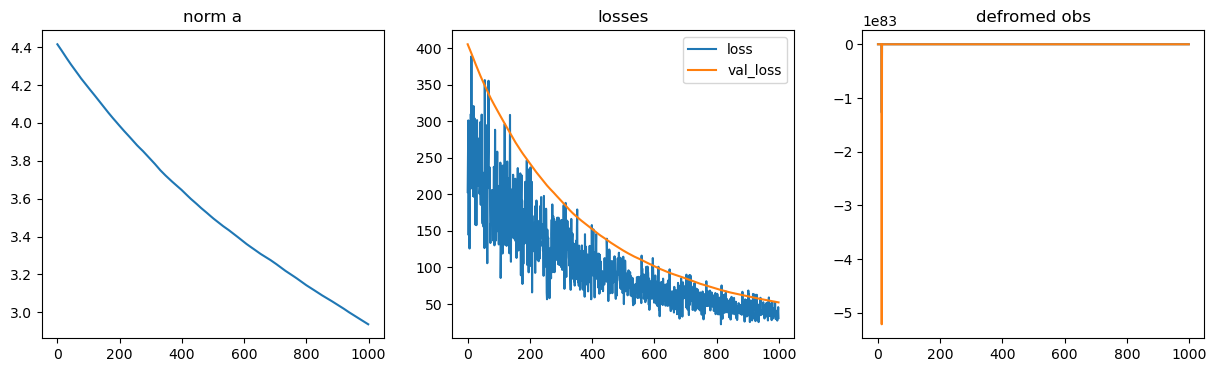

In [ ]:
# MODEL
# p1 = torch.tensor(x,dtype=complex)
# p2 = torch.tensor(y,dtype=complex)

phi = torch.tensor(np.stack([x,y],axis=1),dtype=complex)

a = 0.0*torch.randn(*phi.shape[1:]) # 2 deform params 

beta = 1.0
alpha = 1e-3


split = int(0.7*phi.shape[0])
phi_train = phi[:split]
phi_val = phi[split:]


model = DefObs(obs=def_obs(one_pt_fct), a=a, beta=beta)
optimizer = optim.Adam(model.parameters(),lr=alpha)


anorm = []
losses_train = []
losses_val = []
observable = []

epochs = 1_000

loss_fct = logloss

batch_size = 32

# RUN
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad() # clear grads

    # MINI-BATCHING
    minibatch = np.random.randint(low=0,high=len(phi_train),size=batch_size)

    # TRAIN
    deformed_obs = model(samples=phi_train[minibatch])
    loss_train =loss_fct(deformed_obs)
    loss_train.backward()

    # print(f'grad: {model.a.grad}\n')
    with torch.no_grad():
        observable.append(grab(deformed_obs).mean())

    optimizer.step()

    # VALIDATION
    with torch.no_grad():
        deformed_obs_val = model(samples=phi_val)
        loss_val = loss_fct(deformed_obs_val)
        
        
    
    losses_train.append(grab(loss_train))
    losses_val.append(grab(loss_val))
    anorm.append(np.linalg.norm(grab(a).ravel()))

        

# PLOT

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[0].plot(anorm)
ax[0].set_title('norm a')
ax[1].plot(losses_train,label='loss')
ax[1].plot(losses_val,label='val_loss')
ax[1].legend()
ax[1].set_title('losses')
ax[2].plot([z.real for z in observable],label='re')
ax[2].plot([z.imag for z in observable],label='imag')
ax[2].set_title('defromed obs');

## Defining the Model

### Notation:

$n = \dim_{\mathbb{C}}$

$N = 2n + 2 = \dim_{\mathbb{R}}$

$z, w \in \mathbb{CP}^n \cong \mathbb{R}^{2n + 2} \ni Z, W$

parametrisation: $\tilde Z = X \sqrt{1 + \lVert Y(X)\rvert^2} + i Y(X)$ where $X \in \mathbb{R}^{2n + 2}$



In [15]:
# HELPER FUNCTIONS
def grab(x):
    return x.detach().cpu().numpy()


In [16]:
# GENERATING SAMPLES
n = 2
beta = 1
N_steps = 1_000
burnin = 100
skip = 5

phi0 = torch.randn(2,(2*n + 2),1)
phi0 /= torch.linalg.vector_norm(phi0, dim=1, keepdim=True)

phi, alpha = create_samples(n=n,phi0=phi0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)


100%|██████████| 1000/1000 [00:02<00:00, 382.73it/s]


In [25]:
torch.save(phi, 'foo.dat')

In [26]:
foo = torch.load('foo.dat',weights_only=True)
print(type(foo))

<class 'torch.Tensor'>


**!! Remarks !!** 

* should rename $a$ to $\omega$.

* It would be interesting to see if we could use more Lie theory, namely the rootspace decomposition! I'll try to work this out

In [6]:
# MODEL (n=2) 

# SET HYPERPARAMETERS
beta = 1.0
alpha = 1e-4
i,j = 2, 1 # parameter for fuzzy zero
# obs = lambda phi: two_pt(phi,i)
# obs = lambda phi: fuzzy_zero(phi,i,j)
obs = fuzzy_one

# DEFORMATION
a0 = 0.1*torch.ones_like(phi[0])
deformation = Linear()

# LOSS
loss_fct = loss
loss_name = 'loss' if loss_fct == loss else 'logloss'

# MODEL
model = ZeroDModel(dim_C=n,deformation=deformation,a0=a0,observable=obs,beta=beta) # deformation_param=a

# SET EPOCHS
epochs = 1_000

# TRAINING
observable, observable_var, losses_train, losses_val, anorm, a0, af = train(model,phi,epochs=epochs,loss_fct=loss_fct,)

100%|██████████| 1000/1000 [00:02<00:00, 352.38it/s]


In [5]:
# # MODEL (n=2) 

# # SET HYPERPARAMETERS
# beta = 1.0
# alpha = 1e-4
# i,j = 2, 1 # parameter for fuzzy zero
# # obs = lambda phi: two_pt(phi,i)
# obs = lambda phi: fuzzy_zero(phi,i,j)
# # obs = fuzzy_one

# # DEFORMATION
# # deformation = 'homogeneous'
# # a = None
# a = torch.diag_embed(torch.tensor([[1j,-1j,0]]*2)) # su(n+1)
# # a = torch.diag_embed(torch.tensor([[1j,0,0]]*2)) # u(n+1)
# # a = rho(a) # don't have your param rho(a) but only a -> use rho in method

# # SET LOSS FUNCTION
# loss_fct = loss
# loss_name = 'loss' if loss_fct == loss else 'logloss'

# model = ZeroDModel(dim_C=n,observable=obs,deformation=deformation,a0=a0,beta=beta)

# # SET EPOCHS
# epochs = 1_000

# observable, observable_var, losses_train, losses_val, anorm, a0, af = train(model,phi,epochs=epochs,loss_fct=loss_fct,)

# undeformed_obs = obs(phi)


TypeError: ZeroDModel.__init__() got an unexpected keyword argument 'deformation_param'

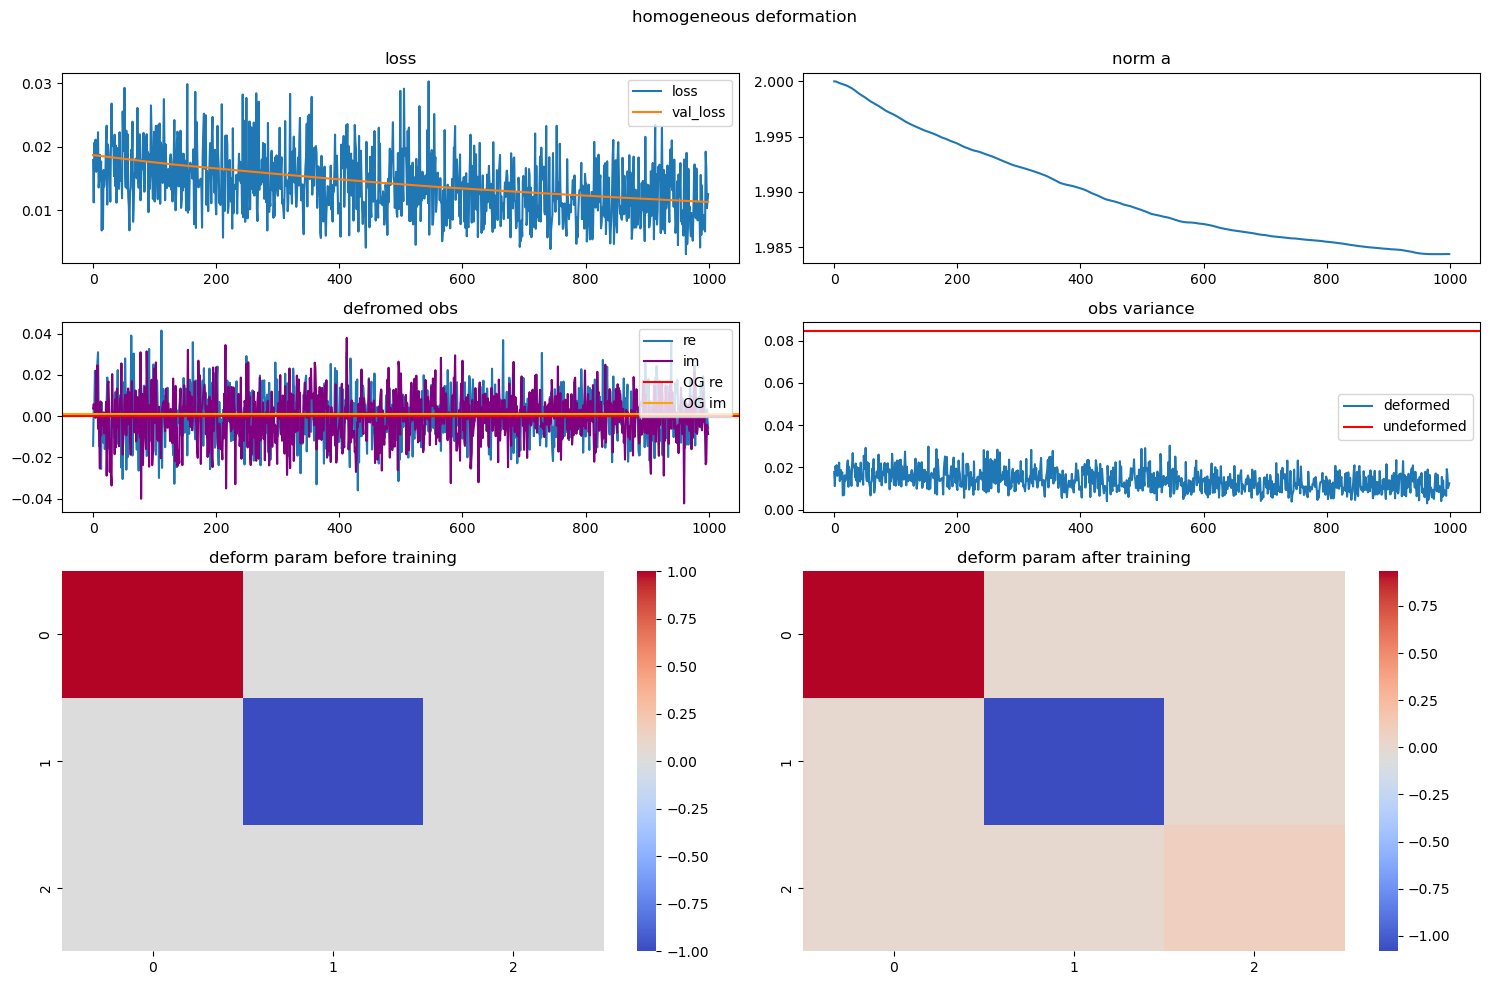

In [30]:
# VARIANCE PLOT
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10),gridspec_kw={'height_ratios': [1, 1, 2]})

plt.suptitle(deformation + ' deformation\n')
ax[0,1].plot(anorm)
ax[0,1].set_title('norm a')

ax[0,0].plot(losses_train,label='loss')
ax[0,0].plot(losses_val,label='val_loss')
ax[0,0].legend()
ax[0,0].set_title(loss_name)
ax[0,0].legend()

ax[1,0].plot([z.real for z in observable],label='re')
ax[1,0].plot([z.imag for z in observable],label='im',color='purple')
ax[1,0].axhline(y=undeformed_obs.mean().real,xmin=0,xmax=phi.shape[0],label='OG re',color='red')
ax[1,0].axhline(y=undeformed_obs.mean().imag,xmin=0,xmax=phi.shape[0],label='OG im',color='orange')
ax[1,0].set_title('defromed obs')
ax[1,0].legend()

ax[1,1].plot([z.real for z in observable_var],label='deformed')
ax[1,1].axhline(y=undeformed_obs.var(),xmin=0,xmax=phi.shape[0],label='undeformed',color='red')
ax[1,1].set_title('obs variance')
ax[1,1].legend()

# if deformation == 'homogeneous' or deformation == 'torus':
sns.heatmap(data=a0[0].imag,ax=ax[2,0],cmap='coolwarm')
ax[2,0].set_title('deform param before training')
sns.heatmap(data=af[0].imag,ax=ax[2,1],cmap='coolwarm')
ax[2,1].set_title('deform param after training')

plt.tight_layout();

## Test 2pt function (toy model)

In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *

from deformations import *
from losses import *
from linalg import *
from observables import *

import analysis as al

In [3]:
def generate_toy_samples(n,beta,N_steps = 10_000, burnin = 1_000, skip = 10):
    """ GENERATING SAMPLES """

    phi0 = torch.randn(2,(2*n + 2),1).double()
    phi0 /= torch.linalg.vector_norm(phi0, dim=1, keepdim=True)

    print("creating samples ... \n")

    phi, alpha = create_samples_II(n=n,phi0=phi0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)

    return phi, alpha

def train_2pt(model,phi,epochs,loss_fct,lr=1e-4,split=0.7,batch_size=32):
    """
    Training.

    Parameters:
    -----------
    model: ZeroDModel
        model to train

    phi: torch.Tensor
        MCMC samples 

    epochs: int
        max number of epochs

    loss_fct: Callable
        loss function 

    lr: float, optional, default = 1e-4
        learning rate

    optimizer: torch.optim.Optimizer, optional, default = None 
        optimizer, if None then set to torch.optim.Adam

    split: flaot, optional, default = 0.7
        percentage of splitting into training and validation set

    Returns:
    --------

    observable: torch.Tensor
        expectation value of the observable

    observable_var: torch.Tensor
        variance of the observable

    losses_train: list[float]
        losses of training set

    losses_val: list[float]
        losses of validation set

    anorm: list[float]
        vector/matrix norm of deformation parameter

    a0: torch.Tensor
        deformation parameter before training

    af: torch.Tensor
        deformation parameter after training
    """
    # TRAIN-TEST SPLIT
    split_ = int(split*phi.shape[0])
    
    phi_train = phi[:split_]
    phi_val = phi[split_:]

    # OPTIMIZER
    optimizer_ = optim.Adam(model.parameters(),lr=lr)
    
    # MINI-BATCHING
    batch_size_ = batch_size

    observable = []
    observable_var = []
    losses_train = []
    losses_val = []

    # TRAINING
    for epoch in tqdm.tqdm(range(epochs)):
        optimizer_.zero_grad()

        # MINI-BATCHING
        minibatch = np.random.randint(low=0,high=len(phi_train),size=batch_size_)

        # TRAIN
        Otilde = model(phi_train[minibatch]) # already expectation value

        loss_train = loss_fct(Otilde)
        loss_train.backward()

        with torch.no_grad():
            observable.append(grab(Otilde).mean())

            observable_var.append(grab(Otilde).mean())

        optimizer_.step()

        # VALIDATION
        with torch.no_grad():
            Otilde_val = model(phi_val) 

            loss_val = loss_fct(Otilde_val)
            
        losses_train.append(grab(loss_train))
        losses_val.append(grab(loss_val))



    return observable, observable_var, losses_train, losses_val


    assert phi.shape[-2] == 2*n + 2, f"phi has wrong (vector, real) dim. Expected {2*n + 2}, got {phi.shape[-2]}"

    X = phi[:,0]
    XS = phi[:,1]

    dtype = X.dtype # I don't like this!

    a_ = rho(1j*su_n.embed(a[0])).to(dtype) # assuming Hermitian su(n) generators 

    outer_XX = X @ X.transpose(-1,-2)

    # DEFORMATION / COMPLEXIFICATION
    Y = a_ @ X 
    inner_YY = Y.transpose(-1,-2) @ Y

    lam = torch.sqrt(1 + inner_YY)

    tildeZ = X * lam + 1j*Y 

    tildeZ = torch.stack((X,XS),dim=1)
    assert tildeZ.shape == phi.shape, "tilde Z has wrong shape!"

    # JACOBIAN
    J = identity*lam - outer_XX @ (a_ @ a_) / lam + 1j*a_
    det = torch.det(J) # (samples, ) 
    print(f"{J.shape = }")
    print(f"{det.shape = }")

    detJ = det / (lam.squeeze(dim=(-1,-2))**2) # incl. extra factor from delta fct

    # detJ = torch.prod(detJ,dim=-1) # total Jacobian (samples,)

    assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 

    return tildeZ, detJ

In [4]:
n=2
Nboot = 1000
betas = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0]
undeformed_obs_re = []
undeformed_obs_im = []

for beta in betas:
    phi, alpha = generate_toy_samples(n,beta)
    obs_ = ToyObs.two_pt_full(phi)
    mean_re, err_re = al.bootstrap(grab(obs_),Nboot=Nboot,f=al.rmean)
    # mean_re, err_re = al.bootstrap(grab(obs_.real),Nboot=Nboot,f=al.rmean)
    # mean_im, err_im = al.bootstrap(grab(obs_.imag),Nboot=Nboot,f=al.imean)
    undeformed_obs_re.append((mean_re,err_re))
    # undeformed_obs_im.append((mean_im,err_im))

print("\ndone")


creating samples ... 



  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:13<00:00, 748.64it/s]


creating samples ... 



100%|██████████| 10000/10000 [00:13<00:00, 722.09it/s]


creating samples ... 



100%|██████████| 10000/10000 [00:13<00:00, 750.16it/s]


creating samples ... 



100%|██████████| 10000/10000 [00:13<00:00, 753.30it/s]


creating samples ... 



100%|██████████| 10000/10000 [00:13<00:00, 752.74it/s]


creating samples ... 



100%|██████████| 10000/10000 [00:13<00:00, 733.16it/s]


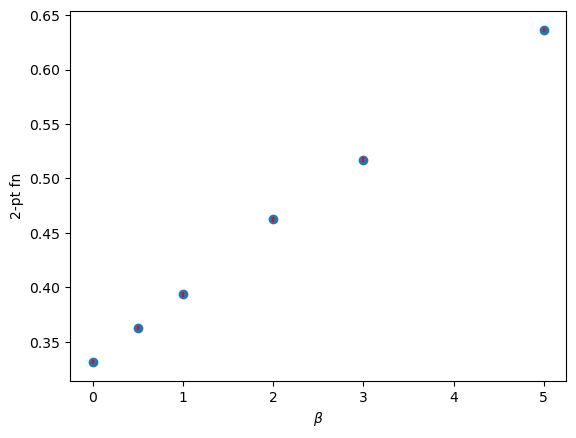

In [6]:
obs_re = np.array([val for val, _ in undeformed_obs_re])
err_obs_re = np.array([err for _, err in undeformed_obs_re])

# obs_im = np.array([val for val, _ in undeformed_obs_im])
# err_obs_im = np.array([err for _, err in undeformed_obs_im])

plt.errorbar(betas,obs_re,err_obs_re,ecolor='red',barsabove=True,marker='o',ls='')
plt.xlabel(r'$\beta$')
plt.ylabel('2-pt fn');

# fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
# ax[0].errorbar(betas,obs_re,err_obs_re,ecolor='red',barsabove=True,marker='o',ls='')
# ax[0].set_xlabel(r'$\beta$')
# ax[0].set_ylabel('2-pt fn')
# ax[0].set_title('real')

# ax[1].errorbar(betas,obs_im,err_obs_im,ecolor='red',barsabove=True,marker='o',ls='')
# ax[1].set_xlabel(r'$\beta$')
# ax[1].set_ylabel('2-pt fn')
# ax[1].set_title('imag')

In [7]:
t = torch.randn(1)
c = torch.cos(t)
s = torch.sin(t)
R = torch.stack([
    torch.cos(t), -torch.sin(t),
    torch.sin(t), torch.cos(t)
], dim=-1).reshape(len(t), 2, 2)

R.shape

torch.Size([1, 2, 2])

In [2]:
# TEST COMPLEXIFY SINGLE FIELD
n = 2
beta = 1.0
dim = n**2 + 2*n
phi = torch.load(f"samples_n{n}_b{beta}.dat",weights_only=True) # n = 2 data
a0 = 0.1*torch.randn(2,dim) # full hom
deformation = Homogeneous(a0,n)

tildeZ, detJ = deformation.complexify_single(phi)

print(f"1st field deformed? {np.allclose(grab(tildeZ[:,0] - phi[:,0]),torch.tensor(0.),atol=1e-12)}")
print(f"2nd field undeformed? {np.allclose(grab(tildeZ[:,1] - phi[:,1]),torch.tensor(0.),atol=1e-12)}")

1st field deformed? False
2nd field undeformed? True


In [3]:
torch.stack([torch.zeros(2,6,1),torch.randn(2,6,1)],dim=0).shape

torch.Size([2, 2, 6, 1])

In [3]:
# TESTING SAMPLES
n= 2
beta = 1.0

phi_, _ = generate_toy_samples(n,beta,N_steps=1000,burnin=100,skip=10)

print(f"all vectors normalised? {torch.allclose((phi_.transpose(-1,-2) @ phi_),torch.tensor(1.,dtype=torch.double),atol=1e-6)}")

print("Testing norms of z, zbar\n")

z, zbar = real2cmplx(phi)

print(f"{z.dtype = }")

print(f"max norm of abs(z*zbar): {torch.abs((z*zbar).squeeze(-1)[:,0]).sum(dim=-1).max()}")

print(f"all norms abs(z*zbar) are 1? {torch.allclose(torch.abs((z*zbar).squeeze(-1)[:,0]).sum(dim=-1),torch.tensor(1.0,dtype=torch.double),atol=1e-4)}")

creating samples ... 



100%|██████████| 1000/1000 [00:03<00:00, 309.02it/s]


In [16]:
################ SET HYPERPARAMETERS ################
n = 2
beta = 1.0

alpha = 1e-3 # learning rate
i,j = 0, 1 # parameter for fuzzy zero
# obs = lambda phi: ToyObs.fuzzy_one(phi)
# obs = lambda phi: ToyObs.one_pt(phi,i,j)
obs = lambda phi: ToyObs.two_pt(phi,i,j)

phi = torch.load(f"samples_n{n}_b{beta}.dat",weights_only=True) # n = 2 data

S = lambda phi: ToyActionFunctional(n).action(phi,beta)

# su(n+1)
deformation_type = "homogeneous"
rk = n
dim = n**2 + 2*n
a0 = 0.1*torch.randn(2,dim) # full hom
deformation = Homogeneous(a0,n)

################ TRAINING ########################

# LOSS
loss_fct = loss
loss_name = 'loss' if loss_fct == loss else 'logloss'

# MODEL
params = [S,deformation,obs,beta]
model = CP(n,*params)

# SET EPOCHS
epochs = 2_000

# TRAINING
print("\n training model ... \n")

observable, observable_var, losses_train, losses_val = train_2pt(model,phi,epochs=epochs,loss_fct=loss_fct,batch_size=1024)

undeformed_obs = obs(phi)

print("\n done.")

Nboot = 1_000
mean_re, err_re = al.bootstrap(grab(undeformed_obs),Nboot=Nboot,f=al.rmean)
mean_im, err_im = al.bootstrap(grab(undeformed_obs),Nboot=Nboot,f=al.imean)


 training model ... 



100%|██████████| 2000/2000 [00:12<00:00, 159.69it/s]



 done.


In [20]:
deformed_mean_re = torch.tensor(observable).real.mean().item()
deformed_mean_im = torch.tensor(observable).imag.mean().item()

print(f"{mean_re = }")
print(f"{mean_im = }")
print(f"{deformed_mean_re = }")
print(f"{deformed_mean_im = }")

mean_re = 0.004711649721418317
mean_im = -0.00010946918784924181
deformed_mean_re = 0.003970026453690639
deformed_mean_im = 0.00025093645385058217


In [30]:
mu = torch.tensor(0.)
std = torch.tensor(2.)
torch.normal(mu,std)

tensor(1.3743)

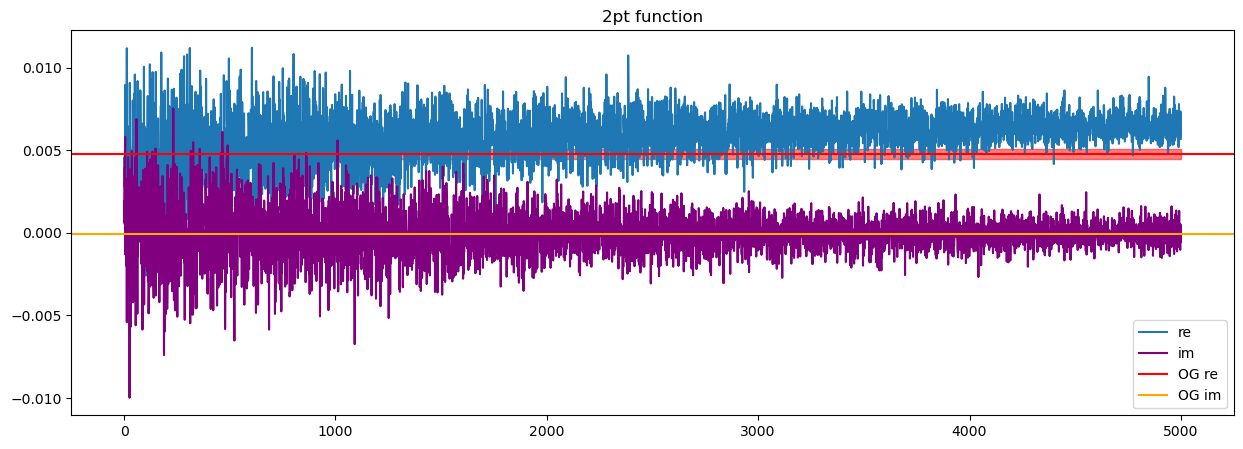

In [14]:
fig = plt.figure(figsize=(15,5))
plt.plot([z.real for z in observable],label='re')
plt.plot([z.imag for z in observable],label='im',color='purple')
plt.axhline(y=mean_re,xmin=0,xmax=epochs,label='OG re',color='red')
plt.axhline(y=mean_im,xmin=0,xmax=epochs,label='OG im',color='orange')
plt.fill_between([0,epochs], [mean_re-err_re]*2, [mean_re+err_re]*2, alpha=0.5, color='red')
plt.fill_between([0,epochs], [mean_im-err_im]*2, [mean_im+err_im]*2, alpha=0.5, color='orange')
plt.title('2pt function')
plt.legend();

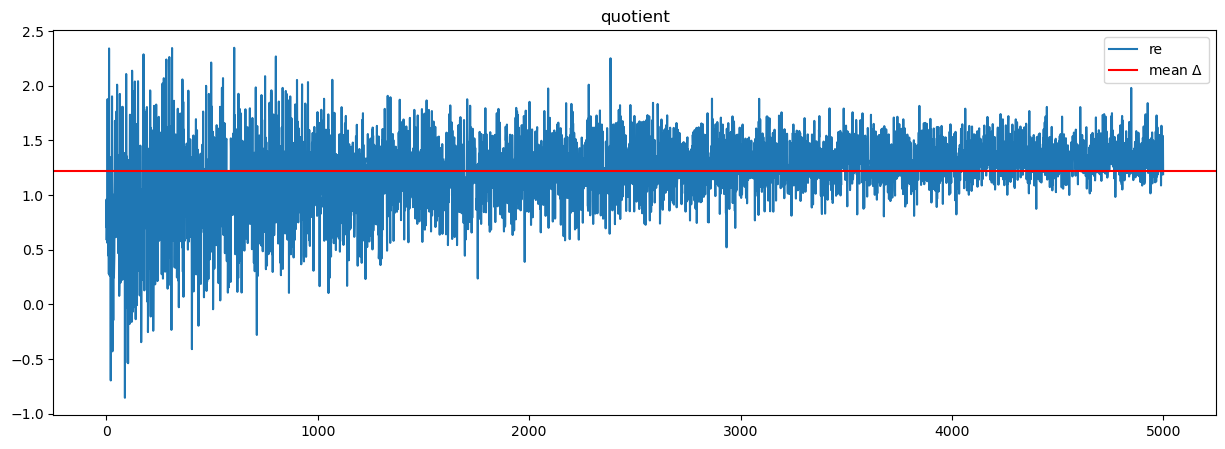

In [15]:
fig = plt.figure(figsize=(15,5))
Delta = [z.real / mean_re for z in observable]
plt.plot(Delta,label='re')
plt.axhline(y=np.mean(Delta),xmin=0,xmax=epochs,color='red',label=r'mean $\Delta$')
# plt.plot([z.imag / mean_im for z in observable],label='im',color='purple')
plt.title('quotient')
plt.legend();

In [ ]:
fig = plt.figure(figsize=(15,5))
Delta = [z.real - mean_re for z in observable]
plt.plot(Delta,label='re')
plt.axhline(y=np.mean(Delta),xmin=0,xmax=epochs,color='red',label=r'mean $\Delta$')
# plt.plot([z.imag / mean_im for z in observable],label='im',color='purple')
plt.title('difference')
plt.legend();

In [9]:
n = 2
rk = n-1
dim = n**2 - 1
su_n = LieSU(n+1)

In [17]:
foo = phi[0,0]
a_ = rho(1j*su_n.embed(a0))[0]
((foo @ foo.transpose(-1,-2)) @ a_ @ a_).shape

torch.Size([6, 6])

## Testing Basis $\mathfrak{su}(n)$

In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *
from deformations import *
from losses import *
from linalg import *
from observables import *

In [20]:
n = 3
rk = n-1
dim = n**2 - 1
su_n = LieSU(n)

h1 = su_n.basis[0]
h2 = su_n.basis[1]

In [26]:
print(f"{h1 = }\n\n")
print(f"{h2 = }")

h1 = tensor([[ 1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j]], dtype=torch.complex128)


h2 = tensor([[ 0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j]], dtype=torch.complex128)


In [3]:
(h1 @ h2).trace().item() # not orthogonal!

(-1+0j)

In [11]:
foo = su_n.rnd_su()
print(f"{foo.shape = }")
print(f"trace = {foo.trace().item()}")
print(f"foo Hermitian: {torch.all(foo == foo.transpose(-1,-2).conj()) }")

foo.shape = torch.Size([3, 3])
trace = 0j
foo Hermitian: True


## Test Torus Deformation

In [32]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *

from deformations import *
from losses import *
from linalg import *
from observables import *

In [17]:
################ SET HYPERPARAMETERS ################
n = 2
beta = 1.0

alpha = 1e-3 # learning rate
i,j = 0, 2 # parameter for fuzzy zero
# obs = fuzzy_one
obs = lambda phi: ToyObs.one_pt(phi,i,j) # fuzzy_zero
# obs = lambda phi: two_pt(phi,i,j)

phi = torch.load(f"samples_n{n}_b{beta}.dat",weights_only=True) # n = 2 data

S = lambda phi: ToyActionFunctional(n).action(phi,beta)

# su(n+1)
deformation_type = "homogeneous"
rk = n
dim = n**2 + 2*n
a0 = 0.1*torch.randn(2,dim) # full hom
# a0 = torch.stack([torch.cat([0.1*torch.randn(rk),torch.zeros(dim-rk)]),torch.cat([0.1*torch.randn(rk),torch.zeros(dim-rk)])],dim=0) # torus
deformation = Homogeneous(a0,n)

################ TRAINING ########################

# LOSS
loss_fct = loss
loss_name = 'loss' if loss_fct == loss else 'logloss'

# MODEL
params = [S,deformation,obs,beta]
model = CP(n,*params)

# SET EPOCHS
epochs = 5_000

# TRAINING
print("\n training model ... \n")

observable, observable_var, losses_train, losses_val, anorm, a0, af = train(model,phi,epochs=epochs,loss_fct=loss_fct,batch_size=1024)

print("\n done.")


 training model ... 



100%|██████████| 5000/5000 [00:56<00:00, 88.32it/s]


 done.


In [19]:
print(f"{(i,j) = }\n")

print(f"{torch.arcsinh(torch.tensor(a0[0])) = }")
print(f"{torch.arcsinh(torch.tensor(af[0])) = }")

tau1 = torch.arcsinh(torch.tensor(af[0]))[0]
tau2 = torch.arcsinh(torch.tensor(af[0]))[1]

print("")
print(f"tau1 = {tau1.item()}")
print(f"tau2 = {tau2.item()}")
print(f"tau1 > tau2 = {(tau1 > tau2).item()}")

(i,j) = (0, 2)

torch.arcsinh(torch.tensor(a0[0])) = tensor([ 0.0132,  0.0738, -0.1944, -0.0897, -0.0448,  0.0074, -0.0192,  0.0594])
torch.arcsinh(torch.tensor(af[0])) = tensor([ 3.8810e-01,  4.3643e-01, -5.0957e-03,  2.8448e-04,  3.8721e-03,
         2.3044e-03, -8.1029e-04,  1.5561e-03])

tau1 = 0.3881032168865204
tau2 = 0.4364279508590698
tau1 > tau2 = False


## Test Specific Torus Deformations 

In [2]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *

from deformations import *
from losses import *
from linalg import *
from observables import *

In [15]:
n = 2
beta = 1.0

# SAMPLES
phi = torch.load(f'samples_n{n}_b{beta:.1f}.dat',weights_only=True)

# ACTION FUNCTIONAL
S = lambda phi: ToyActionFunctional(n).action(phi,beta)

# OBSERVABLE
i,j = 0, 1
obs = lambda phi: ToyObs.two_pt(phi,i,j)

# su(n+1)
deformation_type = "homogeneous"
rk = n
dim = n**2 + 2*n
a0 = 0.01*torch.randn(2,dim) # full hom

deformation = Homogeneous(a0,n)

In [16]:
phi_tilde, detJ = deformation.complexify(phi)

In [17]:
S(phi_tilde) - S(phi)

tensor([ 6.2187e-05+0.0162j,  3.5729e-05+0.0048j, -2.2639e-05+0.0014j,
         ..., -1.6416e-04+0.0076j, -2.6912e-04+0.0198j,
         3.5244e-04+0.0071j], dtype=torch.complex128, grad_fn=<SubBackward0>)

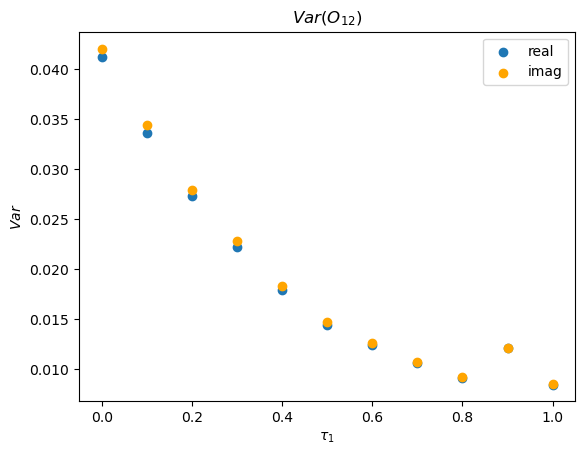

In [166]:
################ SET HYPERPARAMETERS ################
n = 2
beta = 1.0

alpha = 1e-3 # learning rate
i,j = 1, 2  # parameter for fuzzy zero
# obs = fuzzy_one
obs = lambda phi: ToyObs.one_pt(phi,i,j) # fuzzy_zero
# obs = lambda phi: two_pt(phi,i,j)

phi = torch.load(f"samples_n{n}_b{beta:.1f}.dat",weights_only=True) # n = 2 data

S = lambda phi: ToyActionFunctional(n).action(phi,beta)

# su(n+1)
deformation_type = "homogeneous"
rk = n
dim = n**2 + 2*n

rres = []
ires = []
for k in range(11):
    alpha1 = - np.sinh(k/10.)
    alpha2 = 0.0 #- np.sinh(0.1*np.abs(np.random.randn()))
    a0 = torch.stack([torch.cat([torch.tensor([alpha1,alpha2]),torch.zeros(dim-rk)]),torch.cat([0.1*torch.randn(rk),torch.zeros(dim-rk)])],dim=0) # torus
    deformation = Homogeneous(a0,n)
    params = [S,deformation,obs,beta]
    model = CP(n,*params)
    # O = model.obs(phi)
    Otilde = model.deformed_obs(phi)
    rvar = Otilde.real.var() #/ O.real.var()
    ivar = Otilde.imag.var() #/ O.imag.var()
    rres.append(grab(rvar))
    ires.append(grab(ivar))

plt.scatter(np.linspace(0,1,11),rres,label='real')
plt.scatter(np.linspace(0,1,11),ires,label='imag',color='orange')
plt.xlabel(r"$\tau_1$")
plt.ylabel(r"$Var$")
plt.title(f"$Var(O_{{{i}{j}}})$")
plt.legend();

## Test Lattice with random data

In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *
from deformations import *
from losses import *
from linalg import *
from observables import *

In [2]:
n = 2
beta = 1.0

N_samples = 100
Lx = 8
Ly = 8
dim = 2*n + 2

shape = (N_samples,Lx,Ly,dim,1)

# RANDOM TEST SAMPLES
phi = torch.randn(*shape)

phi.shape

torch.Size([100, 8, 8, 6, 1])

In [3]:
# TESTING ACTION FUNCTIONAL
S = lambda phi: LatticeActionFunctional(n).action(phi.cdouble(),beta)
S(phi).shape

torch.Size([100])

In [4]:
# TESTING HOMOGENEOUS DEFORMATION
rk = n
dim = n**2 + 2*n
a0 = 0.1*torch.randn(Lx,Ly,dim) # full hom
deformation = Homogeneous(a0,n,mode="2D")
tildeZ, detJ = deformation.complexify(phi)
print(f"{tildeZ.shape = }")
print(f"{detJ.shape = }")

tildeZ.shape = torch.Size([100, 8, 8, 6, 1])
detJ.shape = torch.Size([100])


In [5]:
# TESTING LINEAR DEFORMATION

a0 = 0.1*torch.randn(phi[0].shape) 
deformation = Linear(a0,n,mode="2D")
tildeZ, detJ = deformation.complexify(phi)
print(f"{tildeZ.shape = }")
print(f"{detJ.shape = }")

lam.shape = torch.Size([100, 8, 8, 1, 1])
tildeZ.shape = torch.Size([100, 8, 8, 6, 1])
detJ.shape = torch.Size([100])


## Test Lattice with actual data

In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *
from deformations import *
from losses import *
from linalg import *
from observables import *

from torch.cuda.amp import autocast

### Testing running / exc times

In [17]:
L = 64
beta = 4.5
Nc = 3
n = 2
u = np.loadtxt(f'cpn_b{beta:.1f}_L{L}_Nc{Nc}_u.dat')[::10]
n_cfg = len(u)
ens = np.fromfile(f'cpn_b{beta:.1f}_L{L}_Nc{Nc}_ens.dat', dtype=np.complex128).reshape(n_cfg, L, L, Nc)
phi = cmplx2real(torch.tensor(ens).unsqueeze(-1)).double()
dim = n**2 + 2*n
identity = torch.eye(2*n + 2)
su_n = LieSU(n+1)
a0 = torch.zeros(L,L,dim)


X = phi
dtype = X.dtype # I don't like this!

with Timer("embedding"):
    a_ = rho(1j*su_n.embed(a0)).to(dtype) # assuming Hermitian su(n) generators 

with Timer("outer_XX"):
    outer_XX = X @ X.transpose(-1,-2)

# DEFORMATION / COMPLEXIFICATION
with Timer("Y"):
    Y = a_ @ X 

with Timer("inner_YY"):
    inner_YY = Y.transpose(-1,-2) @ Y

with Timer("lam"):
    lam = torch.sqrt(1 + inner_YY)

with Timer("tilde Z"):
    tildeZ = X * lam + 1j*Y 

with Timer("outer_XX @ a @ a"):
    outer_XX @ (a_ @ a_)

with Timer("broadcasting outer_XX @ a @ a / lam"):
    outer_XX @ (a_ @ a_) / lam

with Timer("J"):
    J = identity*lam - outer_XX @ (a_ @ a_) / lam + 1j*a_

with Timer("J via einsum"):
    J_einsum = identity * lam - torch.einsum('...ij,...jk->...ik', outer_XX, torch.einsum('...ij,...jk-> ...ik', a_, a_)) / lam + 1j * a_

with Timer("detJ"):
    detJ = torch.det(J)


embedding took 0.0010s
outer_XX took 0.1646s
Y took 0.0965s
inner_YY took 0.0103s
lam took 0.0063s
tilde Z took 0.1412s
outer_XX @ a @ a took 0.5128s
broadcasting outer_XX @ a @ a / lam took 0.3412s
J took 1.0803s
J via einsum took 1.4416s
detJ took 1.2299s


### Testing action values

In [5]:
L = 64
beta = 4.5
Nc = 3
u = np.loadtxt(f'cpn_b{beta:.1f}_L{L}_Nc{Nc}_u.dat')[9::10]
V = L**2
S_tej = beta* V * u # if action is 0 centerd
# S_tej =  - beta * (u - 2) * V # otherwise
n_cfg = len(u)
ens = np.fromfile(f'cpn_b{beta:.1f}_L{L}_Nc{Nc}_ens.dat', dtype=np.complex128).reshape(n_cfg, L, L, Nc)

# prepping
n=2
S = lambda phi: LatticeActionFunctional(n).action_centered(phi.cdouble(),beta)
phi = cmplx2real(torch.tensor(ens).unsqueeze(-1)).double()

print(f"check any lattice point has norm 1: {torch.allclose(torch.linalg.norm(phi.squeeze(-1),dim=-1),torch.tensor(1.0,dtype=torch.double))}")

S_donny = S(phi).real
u_donny = LatticeActionFunctional(n).u(phi.cdouble()).real


check any lattice point has norm 1: True


In [3]:
# TESTING T
n = 2
sigma_y = torch.tensor([[0,1j],[-1j,0]]) # VS overall - sign! To discuss
T = (torch.eye(2*n + 2) + torch.block_diag(*[sigma_y for _ in range(n+1)])).cdouble()

z = ens[0,0,0]
w = ens[0,0,1]
x = z.real
y = z.imag
u = w.real
v = w.imag

X1 = torch.tensor(list(zip(x,y)),dtype=torch.cdouble).flatten().view(-1,1)
X2 = torch.tensor(list(zip(u,v)),dtype=torch.cdouble).flatten().view(-1,1)

XX1 = cmplx2real(torch.tensor(z).unsqueeze(-1)).cdouble()
XX2 = cmplx2real(torch.tensor(w).unsqueeze(-1)).cdouble()


resT = (X1.transpose(-1,-2) @ (T @ X2)).squeeze(-1,-2)

foo = (XX1.transpose(-1,-2) @ (T @ XX2)).squeeze(-1,-2)

res = torch.tensor(np.sum(z.conjugate() * w))

print(f"{(resT - foo).item() = }")
print(f"{(res - foo).item() = }")
print(f"{(resT - res).item() = }")


(resT - foo).item() = 0j
(res - foo).item() = (1.1102230246251565e-16-5.551115123125783e-17j)
(resT - res).item() = (-1.1102230246251565e-16+5.551115123125783e-17j)


In [6]:
from scipy.linalg import block_diag

# Tej's code
def inner(z1, z2):
    return np.sum(np.conj(z1) * z2, axis=-1)

def action(z):
    latt_shape,  N = z.shape[:-1], z.shape[-1]
    S = 0
    for mu in range(len(latt_shape)):
        z_fwd = np.roll(z, -1, axis=mu)
        S += np.sum(np.abs(inner(z_fwd, z))**2 - 1)
    return - beta * S

S_tej_py = []
for i in range(len(ens)):
    S_tej_py.append(action(ens[i]))

S_tej_py = torch.tensor(S_tej_py)

################################################################################################################################################

def action_donny(phi):
    n = 2
    sigma_y = np.array([[0,1j],[-1j,0]]) 
    T = (np.eye(2*n + 2) + block_diag(*[sigma_y for _ in range(n+1)]))
    
    S = 0
    for mu in range(2):
        z_fwd = (np.transpose(phi,axes=(0,1,3,2)) @ (T @ np.roll(phi,-1,axis=mu))).flatten()
        zbar_fwd = (np.transpose(np.roll(phi,-1,axis=mu),axes=(0,1,3,2)) @ (T @ phi)).flatten()

        S += np.sum(z_fwd * zbar_fwd - 1.0)
        
    return - beta * S

S_donny_py = []
for i in range(len(ens)):
    S_donny_py.append(action_donny(phi[i].numpy()))

S_donny_py = torch.tensor(S_donny_py)


################################################################################################################################################

# n = 2
# sigma_y = torch.tensor([[0,1j],[-1j,0]]) # VS overall - sign! To discuss
# T = (torch.eye(2*n + 2) + torch.block_diag(*[sigma_y for _ in range(n+1)])).cdouble()

# S_donny = torch.zeros(phi.shape[0],dtype=torch.cdouble)

# for mu in [-3,-4]:
#     z_fwd = ( phi.cdouble().transpose(-1,-2) @ (T @ torch.roll(phi.cdouble(),-1,dims=mu) ) ).squeeze(-1,-2) 
#     zbar_fwd = ( torch.roll(phi.cdouble(),-1,dims=mu).transpose(-1,-2) @ (T @ phi.cdouble() ) ).squeeze(-1,-2) 

#     S_donny += -beta*(z_fwd * zbar_fwd - 1.0).sum(dim=(-1,-2)) # trivial shift, zero centered

print(f"max(|S_donny_py - S_donny|) = {np.abs(S_donny_py - S_donny).max()}")
print(f"max(|S_donny_py - S_tej_py|) = {np.abs(S_donny_py - S_tej_py).max()}")

max(|S_donny_py - S_donny|) = 5.457001293992583e-12
max(|S_donny_py - S_tej_py|) = 3.63807241885356e-12


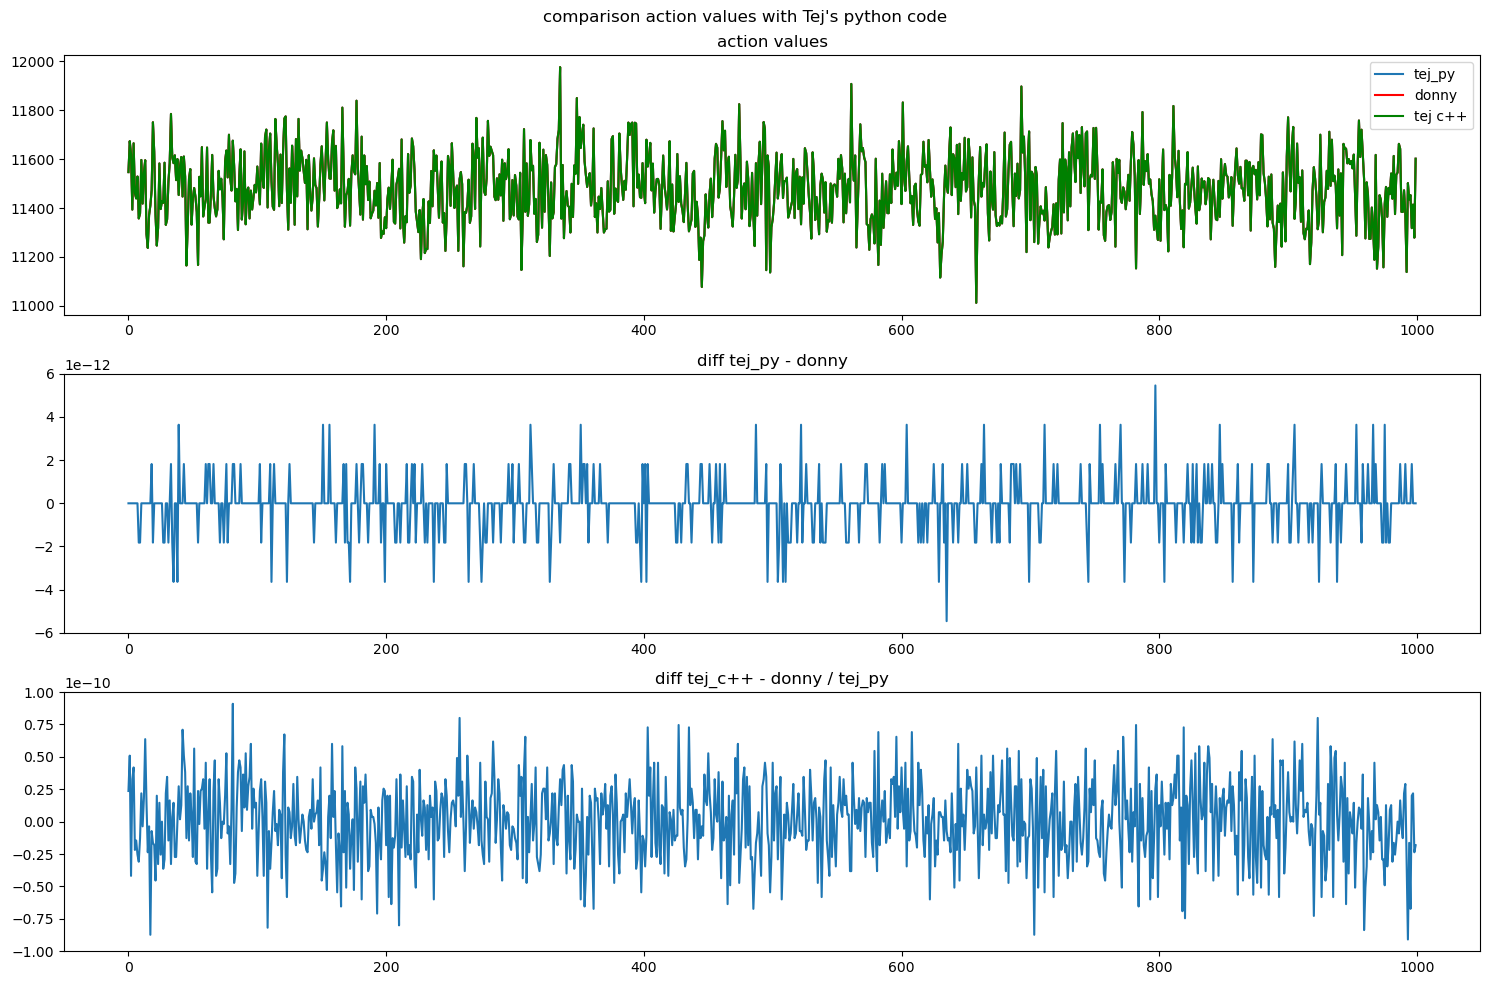

In [7]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(15,10))
ax[0].plot(S_tej_py,label='tej_py')
ax[0].plot(S_donny.real,color='red',label='donny')
ax[0].plot(S_tej.real,color='green',label='tej c++')
ax[0].legend()
ax[0].set_title("action values")
ax[1].plot(S_tej_py-S_donny.real)
ax[1].set_title("diff tej_py - donny")
ax[2].plot(S_tej-S_donny.numpy())
ax[2].set_title("diff tej_c++ - donny / tej_py")
plt.suptitle("comparison action values with Tej's python code")
plt.tight_layout();

In [8]:
atol = 1e-12

print("comparing ens and phi")
print('='*21,'\n')
print("comparing real part")
print('-'*19,'\n')
print(f"Ex: ens[0,0,0].real : {ens[0,0,0].real}")
print(f"Ex: phi[0,0,0].real: {phi[0,0,0][::2].squeeze(-1).numpy()}")
print(f"(ens-phi)[0,0,0].real: {ens[0,0,0].real - phi[0,0,0][::2].squeeze(-1).numpy()}")
print(f"max overall diff.real: {(ens.real - phi[:,:,:,::2].squeeze(-1).numpy()).max()}")
print(f"diff < {atol}? {np.allclose(ens.real - phi[:,:,:,::2].squeeze(-1).numpy(),np.zeros_like(ens.real),atol=atol)}")
print("")
print("comparing imag part")
print('-'*19,'\n')
print(f"Ex: ens[0,0,0].imag : {ens[0,0,0].imag}")
print(f"Ex: phi[0,0,0].imag: {phi[0,0,0][1::2].squeeze(-1).numpy()}")
print(f"(ens-phi)[0,0,0].imag: {ens[0,0,0].imag - phi[0,0,0][1::2].squeeze(-1).numpy()}")
print(f"max overall diff.imag: {(ens.imag - phi[:,:,:,1::2].squeeze(-1).numpy()).max()}")
print(f"diff < {atol}? {np.allclose(ens.imag - phi[:,:,:,1::2].squeeze(-1).numpy(),np.zeros_like(ens.imag),atol=atol)}")
print("")
print("comparing real2cmplx(cmplx2real(ens)) with ens")
print('-'*46,'\n')
z, _ = real2cmplx(cmplx2real(torch.tensor(ens).unsqueeze(-1)))
z = z.squeeze(-1).numpy()
print("z ~ real2cmplx(cmplx2real(ens))\n")
print(f"(z - ens).real < {atol}? {np.allclose((z - ens).real,np.zeros_like(ens.real),atol=atol)}")
print(f"(z - ens).imag < {atol}? {np.allclose((z - ens).imag,np.zeros_like(ens.imag),atol=atol)}")


comparing ens and phi

comparing real part
------------------- 

Ex: ens[0,0,0].real : [ 0.45371633  0.36542429 -0.35560811]
Ex: phi[0,0,0].real: [ 0.45371633  0.36542429 -0.35560811]
(ens-phi)[0,0,0].real: [0. 0. 0.]
max overall diff.real: 0.0
diff < 1e-12? True

comparing imag part
------------------- 

Ex: ens[0,0,0].imag : [ 0.04103264 -0.17245151 -0.70903191]
Ex: phi[0,0,0].imag: [ 0.04103264 -0.17245151 -0.70903191]
(ens-phi)[0,0,0].imag: [0. 0. 0.]
max overall diff.imag: 0.0
diff < 1e-12? True

comparing real2cmplx(cmplx2real(ens)) with ens
---------------------------------------------- 

z ~ real2cmplx(cmplx2real(ens))

(z - ens).real < 1e-12? True
(z - ens).imag < 1e-12? True


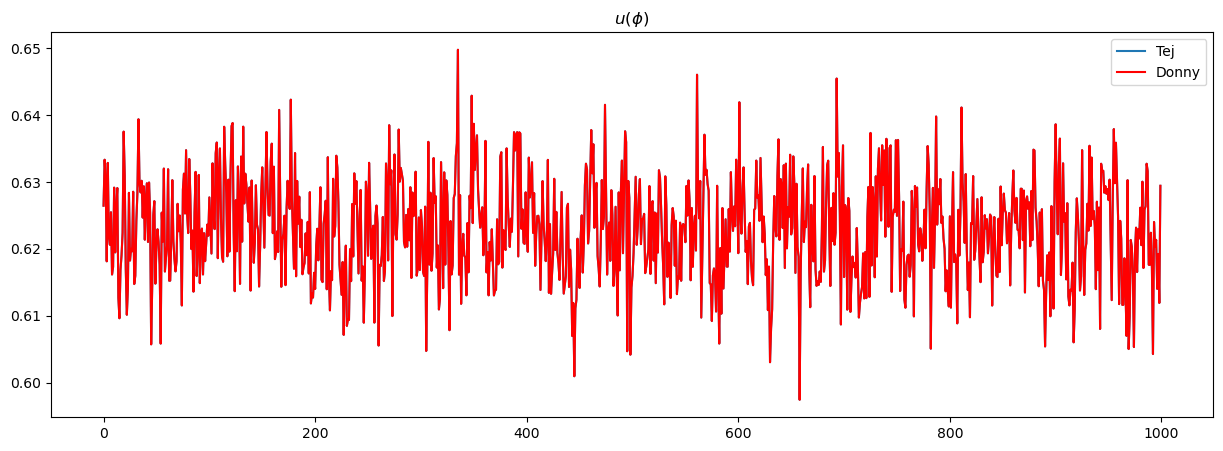

In [9]:
fig = plt.figure(figsize=(15,5))
plt.plot(u,label='Tej')
plt.plot(u_donny, label='Donny',color='red')
plt.title(r"$u(\phi)$")
plt.legend();

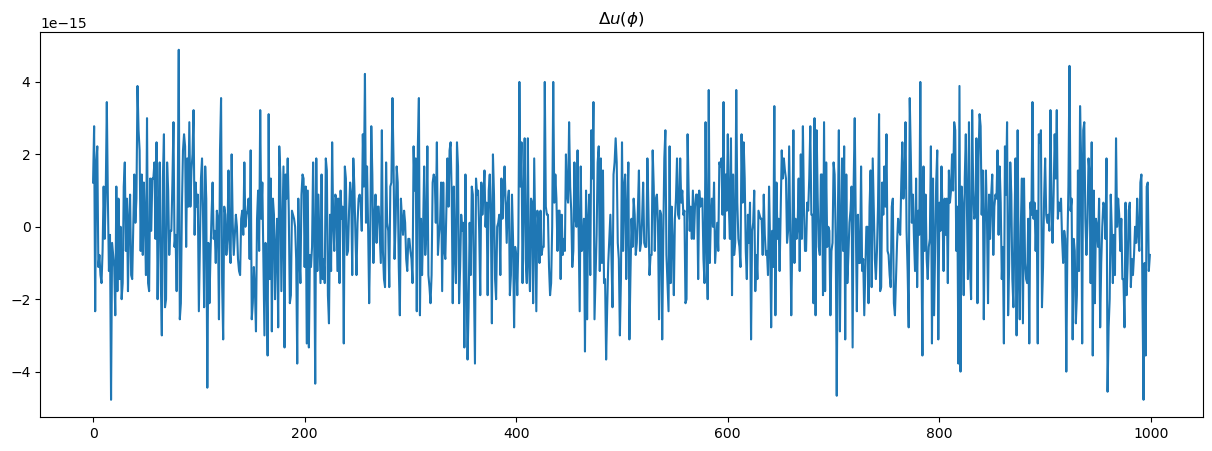

In [10]:
fig = plt.figure(figsize=(15,5))
plt.plot(u - u_donny.numpy())
plt.title(r"$\Delta u(\phi)$");

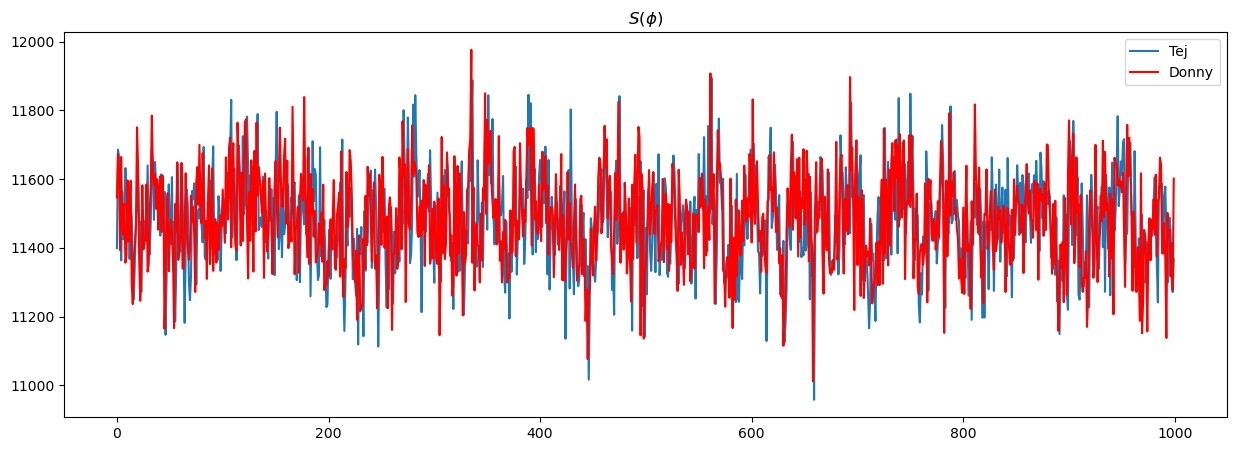

In [10]:
fig = plt.figure(figsize=(15,5))
plt.plot(S_tej,label='Tej')
plt.plot(S_donny, label='Donny',color='red')
plt.title(r"$S(\phi)$")
plt.legend();

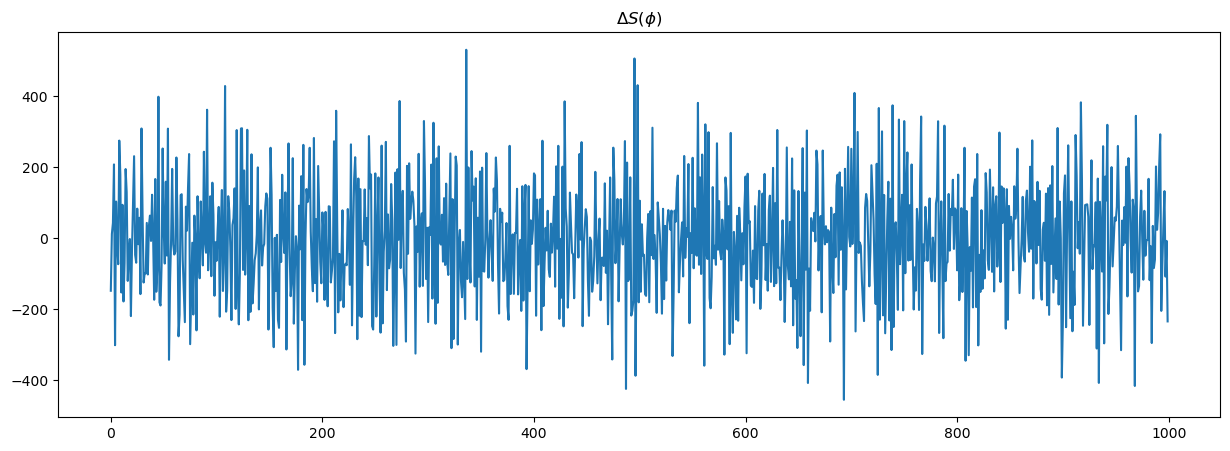

In [19]:
fig = plt.figure(figsize=(15,5))
plt.plot(S_tej - S_donny.numpy())
plt.title(r"$\Delta S(\phi)$");

### Testing fuzzy 1

In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt

from mcmc import *
from model import *
from deformations import *
from losses import *
from linalg import *
from observables import *

from torch.cuda.amp import autocast

In [14]:
phi_tilde, detJ = deformation.complexify(phi)

In [5]:
L = 64
beta = 4.5
Nc = 3
n_cfg = 1_000
print("Reading samples..\n")
ens = np.fromfile(f'cpn_b{beta:.1f}_L{L}_Nc{Nc}_ens.dat', dtype=np.complex128).reshape(n_cfg, L, L, Nc)
print("...done\n")

# SAMPLES
n=2
rk = n
dim = n**2 + 2*n

print("Preparing samples..\n")
phi = cmplx2real(torch.tensor(ens).unsqueeze(-1))
print("...done\n")
print(f"{phi.shape = }")
print(f"{phi.dtype = }")

# ACTION FUNCTIONAL
S = lambda phi: LatticeActionFunctional(n).action_centered(phi.cdouble(),beta)

# OBSERVABLE
i,j = 0, 1 
obs = LatObs.fuzzy_one
# obs = lambda phi: LatObs.one_pt(phi,i,j) # fuzzy_zero
# obs = lambda phi: LatObs.two_pt(phi,i,j)

a0 = 0.001 * torch.rand(L,L,dim)
deformation = Homogeneous(a0,n,mode="2D")

deformation_type = "lattice"

batch_size = 16
alpha = 1e-4

# LOSS
loss_fct = loss
loss_name = 'loss' if loss_fct == loss else 'logloss'

# MODEL
params = dict(
    action = S,
    deformation = deformation,
    observable = obs,
    beta = beta
)
model = CP(n,**params)

# SET EPOCHS
epochs = 10

# TRAINING
print("\n training model ... \n")

observable, observable_var, losses_train, losses_val, anorm, a0, af = train(model,phi,epochs=epochs,loss_fct=loss_fct,batch_size=batch_size,lr=alpha)

print("\n done.\n")

undeformed_obs = obs(phi)

Reading samples..

...done

Preparing samples..

...done

phi.shape = torch.Size([1000, 64, 64, 6, 1])
phi.dtype = torch.float64

 training model ... 



100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


 done.



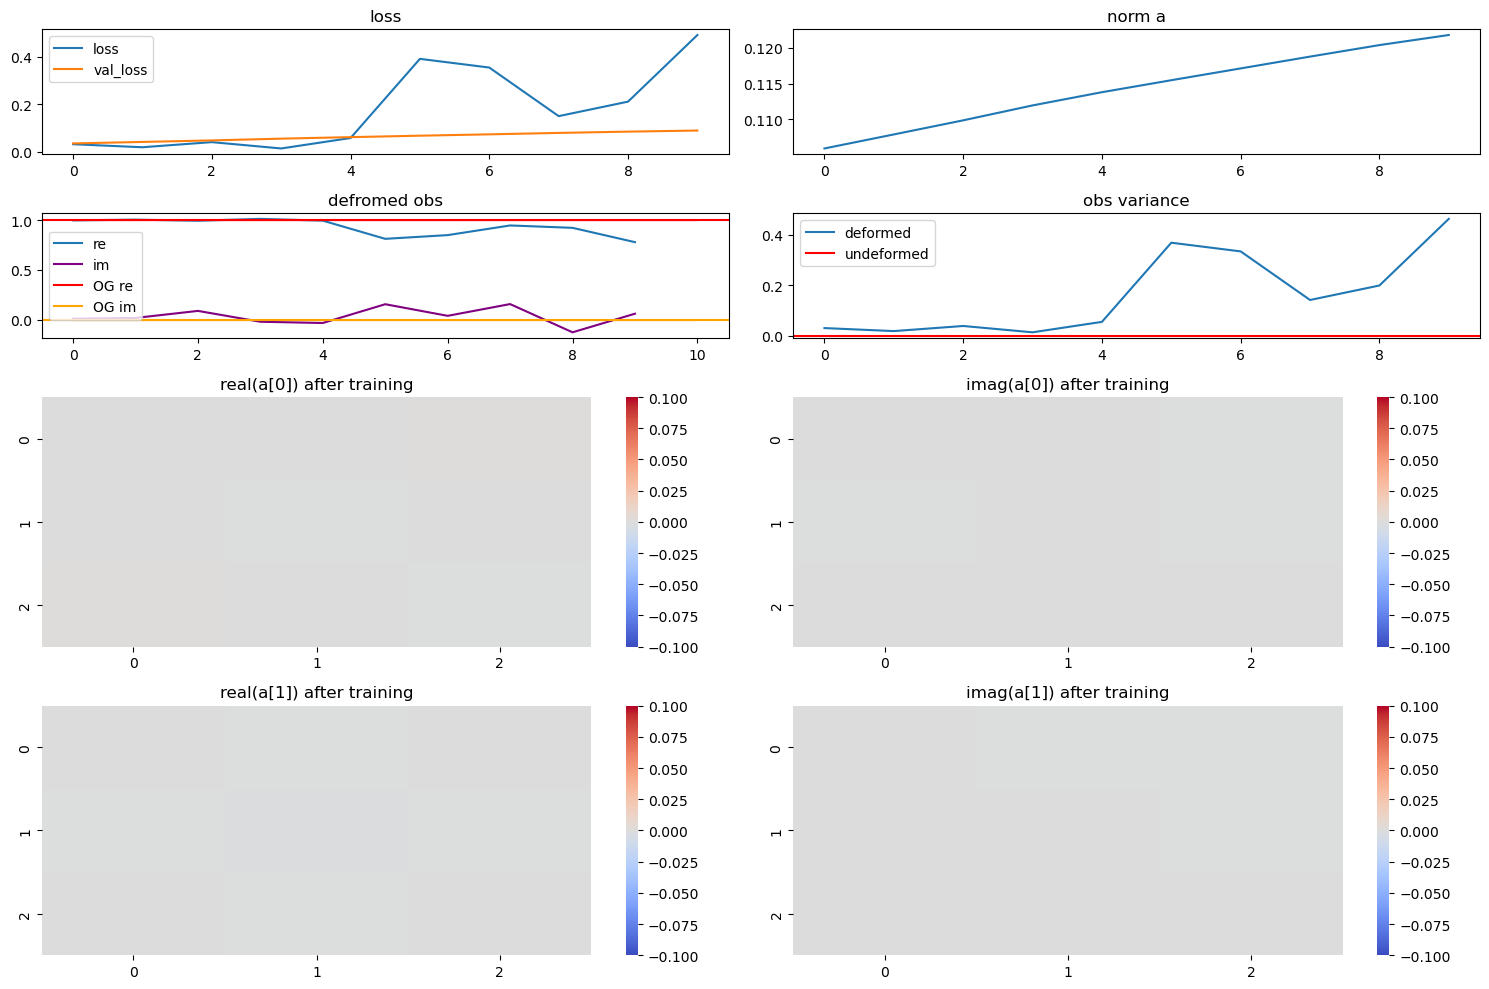

In [6]:
import analysis as al
import seaborn as sns

epochs = len(observable)


Nboot = 100
mean_re, err_re = al.bootstrap(grab(undeformed_obs),Nboot=Nboot,f=al.rmean)
mean_im, err_im = al.bootstrap(grab(undeformed_obs),Nboot=Nboot,f=al.imean)


# LINEAR DEFORMATION
if deformation_type == "linear":
    aZ = torch.tensor(af[0]).cfloat()
    aW = torch.tensor(af[1]).cfloat()
elif deformation_type == "homogeneous":
# HOMOGENEOUS DEFORMATION
    su_n = LieSU(n+1)
    aZ = su_n.embed(torch.tensor(af[0]))
    aW = su_n.embed(torch.tensor(af[1]))
else:
    su_n = LieSU(n+1)
    aZ = su_n.embed(torch.tensor(af[0,0]))
    aW = su_n.embed(torch.tensor(af[0,1]))


fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(15,10),gridspec_kw={'height_ratios': [1, 1, 2, 2]})

ax[0,1].plot(anorm)
ax[0,1].set_title('norm a')

ax[0,0].plot(losses_train,label='loss')
ax[0,0].plot(losses_val,label='val_loss')
ax[0,0].legend()
ax[0,0].set_title(loss_name)
ax[0,0].legend()

ax[1,0].plot([z.real for z in observable],label='re')
ax[1,0].plot([z.imag for z in observable],label='im',color='purple')
ax[1,0].axhline(y=mean_re,xmin=0,xmax=epochs,label='OG re',color='red')
ax[1,0].axhline(y=mean_im,xmin=0,xmax=epochs,label='OG im',color='orange')
ax[1,0].fill_between([0,epochs], [mean_re-err_re]*2, [mean_re+err_re]*2, alpha=0.5, color='red')
ax[1,0].fill_between([0,epochs], [mean_im-err_im]*2, [mean_im+err_im]*2, alpha=0.5, color='orange')
ax[1,0].set_title('defromed obs')
ax[1,0].legend()

ax[1,1].plot([z.real for z in observable_var],label='deformed')
ax[1,1].axhline(y=undeformed_obs.var(),xmin=0,xmax=epochs,label='undeformed',color='red')
ax[1,1].set_title('obs variance')
ax[1,1].legend()

sns.heatmap(data=aZ.real,ax=ax[2,0],cmap='coolwarm',vmin=-0.1,vmax=0.1)
ax[2,0].set_title('real(a[0]) after training')
sns.heatmap(data=aZ.imag,ax=ax[2,1],cmap='coolwarm',vmin=-0.1,vmax=0.1)
ax[2,1].set_title('imag(a[0]) after training')

sns.heatmap(data=aW.real,ax=ax[3,0],cmap='coolwarm',vmin=-0.1,vmax=0.1)
ax[3,0].set_title('real(a[1]) after training')
sns.heatmap(data=aW.imag,ax=ax[3,1],cmap='coolwarm',vmin=-0.1,vmax=0.1)
ax[3,1].set_title('imag(a[1]) after training')

plt.tight_layout()
plt.show();

## MISC & TESTS

In [562]:
# CREATING BLOCK DIAG MATRICES WITH BATCHING blkdiag
a = torch.randint(low=0,high=9,size=(1,3,2,2))
b = torch.randint(low=0,high=9,size=(1,3,2,2))
c = torch.randint(low=0,high=9,size=(1,3,2,2))

print(f'{a.shape = }\n')
arrs = [a,b,c]
shapes = np.array([i.shape for i in arrs])

print(f'{shapes = }\n')

print(f'{shapes[0,:-2] = }\n')

print(f'{list(shapes[0,:-2])+[shapes[:, -1].sum(), shapes[:,-2].sum()]}\n')

# np.zeros([shapes[:, i].sum() for i in range(len(arrs))])

# print(f'{a = }\n')
# print(f'{b = }\n')
# print(f'{c = }\n')
M = blkdiag(arrs)
print(f'{M.shape = }\n')
print(M)



a.shape = torch.Size([1, 3, 2, 2])

shapes = array([[1, 3, 2, 2],
       [1, 3, 2, 2],
       [1, 3, 2, 2]])

shapes[0,:-2] = array([1, 3])

[1, 3, 6, 6]

M.shape = torch.Size([1, 3, 6, 6])

tensor([[[[7., 5., 0., 0., 0., 0.],
          [3., 5., 0., 0., 0., 0.],
          [0., 0., 6., 5., 0., 0.],
          [0., 0., 8., 3., 0., 0.],
          [0., 0., 0., 0., 6., 1.],
          [0., 0., 0., 0., 0., 8.]],

         [[3., 2., 0., 0., 0., 0.],
          [8., 4., 0., 0., 0., 0.],
          [0., 0., 0., 8., 0., 0.],
          [0., 0., 0., 6., 0., 0.],
          [0., 0., 0., 0., 0., 5.],
          [0., 0., 0., 0., 2., 4.]],

         [[1., 5., 0., 0., 0., 0.],
          [1., 2., 0., 0., 0., 0.],
          [0., 0., 6., 7., 0., 0.],
          [0., 0., 4., 7., 0., 0.],
          [0., 0., 0., 0., 8., 7.],
          [0., 0., 0., 0., 1., 0.]]]])


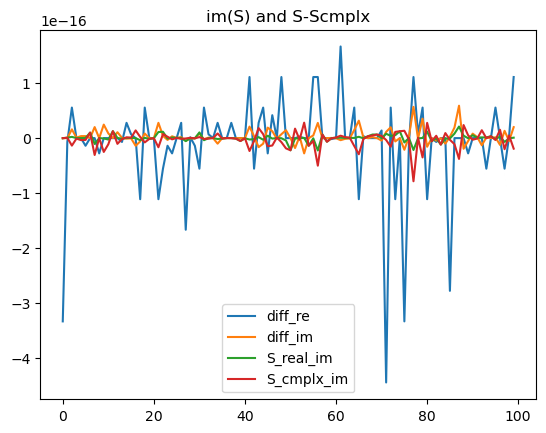

In [36]:
# TESTING S : REAL VS CMPLX

# REAL SETUP
n = 3 # complex dimension of CP^n

diff_re, diff_im, S_real_im, S_cmplx_im = [], [], [], []

for i in range(100):
    Z = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    Z/= np.linalg.norm(Z)

    W = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    W /= np.linalg.norm(W)


    # COMPARISON WITH COMPLEX ACTION
    reZ = Z[0::2]
    imZ = Z[1::2]

    reW = W[0::2]
    imW = W[1::2]

    z = np.array([a + b*1j for a,b in zip(reZ,imZ)])
    w = np.array([a + b*1j for a,b in zip(reW,imW)])

    # DIM NEEDED FOR S (samples,2n+2,1)
    Z = Z[np.newaxis,:,:]
    W = W[np.newaxis,:,:]

    # print(f'{S(n,Z,W,beta=1) = }')
    # print(f'{Scmplx(z.flatten(),w.flatten(),beta=1) = }')
    diff_re.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real)
    diff_im.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).imag)
    S_real_im.append(S(n,Z,W,beta=1).imag)
    S_cmplx_im.append(Scmplx(z.flatten(),w.flatten(),beta=1).imag)

# print(f'S - Scmpl = {(S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real}')
names = ['diff_re','diff_im','S_real_im','S_cmplx_im']
i = 0
for f in [diff_re,diff_im,S_real_im,S_cmplx_im]:
    plt.plot(f,label=names[i])
    i+=1

plt.title('im(S) and S-Scmplx')
plt.legend();

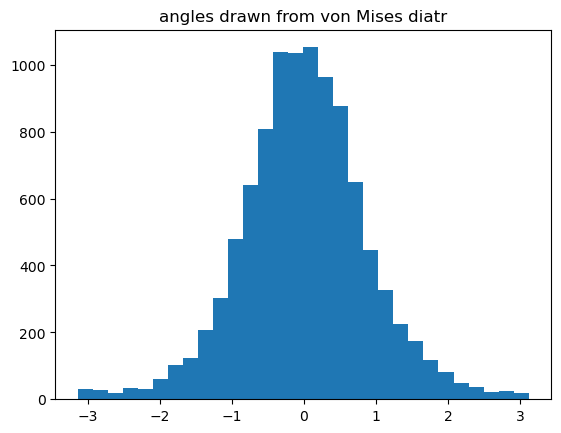

In [52]:
data = np.random.vonmises(0.0,2,size=10_000)
plt.hist(data,bins=30)
plt.title('angles drawn from von Mises diatr');

In [53]:
# TESTING DIFFS
x = np.array([1,0,0])
y = np.array([0,1,0])

u = np.array([1,0,0])
v = np.array([0,1,0])

z = 1 + 2j

x_prime,y_prime = invPsi(Psi((x,y)))
print(f'{x_prime - x = }')
print(f'{y_prime - y = }')

w = Psi(invPsi(z))
print(f'{w - z = }')

x_prime - x = array([0., 0., 0.])
y_prime - y = array([0., 0., 0.])
w - z = 0j
